In [1]:
import matplotlib.pyplot as plt
from stable_baselines3.ppo import PPO
from stable_baselines3.ppo.policies import MlpPolicy

from gym_pcgrl.wrappers import SwapFullWrapper
from utils import generate_preset_diff

In [2]:
BALANCING = 0.5 # indicating both players win equally often

In [3]:
# define environment
def create_env(env="nmmodiff"):
    env_config = {
        "sim_runs": 10,
        # this defines the map generator
        "init_random_map": generate_preset_diff,
        "width": 6,
        "height": 6,
        "b_method": 0,
        "balancing": BALANCING
    }
    env_name = '{}-{}-v0'.format(env, "swap")
    return SwapFullWrapper(env_name, **env_config)

In [4]:
# create env
env = create_env()
obs, stats = env.reset()
print("Initial balancing of random level:", stats["balancing"])

Initial balancing of random level: 0.33000000000000007


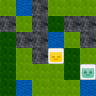

In [9]:
# example how an unbalanced level would look like
env.render()

In [6]:
# load model
path = f"models/wide_swap/balancing_{str(BALANCING).replace('.', '_')}.zip"
model = PPO(MlpPolicy, env, n_steps=128).load(path, env)

In [7]:
def inference(model_, env, render=False):
    obs, _ = env.reset()
    init_info = env.unwrapped.get_rep_stats()
    init_map = env.unwrapped.get_map()
    
    if render is True:
        print("Balancing start", round(init_info["balancing"], 1)) #, "Steps start", init_info["steps"]
        initial_level = env.render()
        
    reward_total = 0
    for i in range(100):
        action, _ = model_.predict(obs)
        obs, reward, done, trunc, info = env.step(action)
        reward_total += reward
        if done:
            break
            
    if render is True:
        print("Balancing after", round(info["balancing"], 1))
        show_compared(env, initial_level, info['iterations'], info['changes'], reward_total, initial_level)
    info["init-balancing"] = init_info["balancing"]
    info["init-map"] = init_map
    info["map"] = env.unwrapped.get_map()
    return env, info, reward_total

def show_compared(env, initial_level, step=0, changes=0, total_reward=0, name=""):
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))

    fig.suptitle("Step: {} Changes: {} Total Reward: {}".format(step, changes, total_reward))
    ax1.imshow(initial_level)
    ax1.set_title("Before")
    ax1.axis("off")
    ax2.imshow(env.render())
    ax2.set_title("After")
    ax2.axis("off")

Balancing start 1.0
Balancing after 0.5


<Figure size 250x250 with 0 Axes>

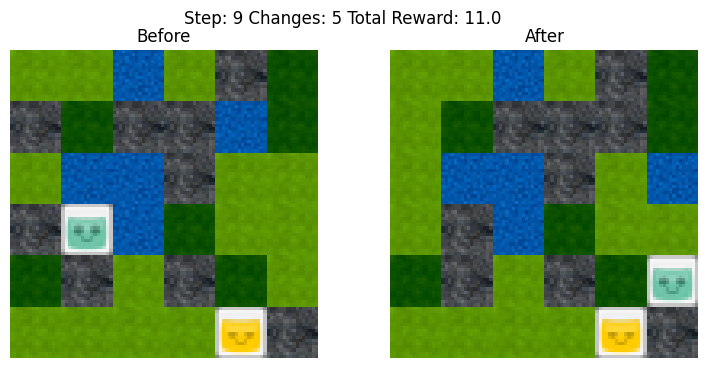

In [16]:
# do balancing with model
env, info, reward = inference(model, env, render=True)

In the demo example above, a maximal unbalanced level (before: score 1.0) has been balanced towards a balanced level (score 0.5). The green player had been locked away behind water and rock tiles, making it impossible to gather resources. In the balanced version, among other things, the start position of that player has been swapped towards a better start position.